In [1]:
import tensorflow as tf
import sys

def _combined_static_and_dynamic_shape(tensor):
  """Returns a list containing static and dynamic values for the dimensions.
  Returns a list of static and dynamic values for shape dimensions. This is
  useful to preserve static shapes when available in reshape operation.
  Args:
    tensor: A tensor of any type.
  Returns:
    A list of size tensor.shape.ndims containing integers or a scalar tensor.
  """
  static_tensor_shape = tensor.shape.as_list()
  dynamic_tensor_shape = tf.shape(input=tensor)
  combined_shape = []
  for index, dim in enumerate(static_tensor_shape):
    if dim is not None:
      combined_shape.append(dim)
    else:
      combined_shape.append(dynamic_tensor_shape[index])
  return combined_shape

def scatter_nd_with_pool(index,
                         value,
                         shape,
                         pool_method=tf.math.unsorted_segment_max):
  """Similar as tf.scatter_nd but allows custom pool method.
  tf.scatter_nd accumulates (sums) values if there are duplicate indices.
  Args:
    index: [N, 2] tensor. Inner dims are coordinates along height (row) and then
      width (col).
    value: [N, ...] tensor. Values to be scattered.
    shape: (height,width) list that specifies the shape of the output tensor.
    pool_method: pool method when there are multiple points scattered to one
      location.
  Returns:
    image: tensor of shape with value scattered. Missing pixels are set to 0.
  """
  if len(shape) != 2:
    raise ValueError('shape must be of size 2')
  height = shape[0]
  width = shape[1]
  # idx: [N]
  index_encoded, idx = tf.unique(index[:, 0] * width + index[:, 1])
  value_pooled = pool_method(value, idx, tf.size(input=index_encoded))
  index_unique = tf.stack(
      [index_encoded // width,
       tf.math.mod(index_encoded, width)], axis=-1)
  shape = [height, width]
  value_shape = _combined_static_and_dynamic_shape(value)
  if len(value_shape) > 1:
    shape = shape + value_shape[1:]

  image = tf.scatter_nd(index_unique, value_pooled, shape)
  return image

def build_camera_depth_image(range_image_cartesian,
                             extrinsic,
                             camera_projection,
                             camera_image_size,
                             camera_name,
                             pool_method=tf.math.unsorted_segment_min,
                             scope=None):
  """Builds camera depth image given camera projections.
  The depth value is the distance between a lidar point and camera frame origin.
  It is decided by cartesian coordinates in vehicle frame and the camera
  extrinsic. Optionally, the cartesian coordinates can be set in the vehicle
  frame corresponding to each pixel pose which makes the depth generated to have
  vehicle motion taken into account.
  Args:
    range_image_cartesian: [B, H, W, 3] tensor. Range image points in vehicle
      frame. Note that if the range image is provided by pixel_pose, then you
      can optionally pass in the cartesian coordinates in each pixel frame.
    extrinsic: [B, 4, 4] tensor. Camera extrinsic.
    camera_projection: [B, H, W, 6] tensor. Each range image pixel is associated
      with at most two camera projections. See dataset.proto for more details.
    camera_image_size: a list of [height, width] integers.
    camera_name: an integer that identifies a camera. See dataset.proto.
    pool_method: pooling method when multiple lidar points are projected to one
      image pixel.
    scope: the name scope.
  Returns:
    image: [B, height, width] depth image generated.
  """
  with tf.compat.v1.name_scope(
      scope, 'BuildCameraDepthImage',
      [range_image_cartesian, extrinsic, camera_projection]):
    # [B, 4, 4]
    vehicle_to_camera = tf.linalg.inv(extrinsic)
    # [B, 3, 3]
    vehicle_to_camera_rotation = vehicle_to_camera[:, 0:3, 0:3]
    # [B, 3]
    vehicle_to_camera_translation = vehicle_to_camera[:, 0:3, 3]
    # [B, H, W, 3]
    range_image_camera = tf.einsum(
        'bij,bhwj->bhwi', vehicle_to_camera_rotation,
        range_image_cartesian) + vehicle_to_camera_translation[:, tf.newaxis,
                                                               tf.newaxis, :]
    # [B, H, W]
    range_image_camera_norm = tf.norm(tensor=range_image_camera, axis=-1)
    camera_projection_mask_1 = tf.tile(
        tf.equal(camera_projection[..., 0:1], camera_name), [1, 1, 1, 2])
    camera_projection_mask_2 = tf.tile(
        tf.equal(camera_projection[..., 3:4], camera_name), [1, 1, 1, 2])
    camera_projection_selected = tf.ones_like(
        camera_projection[..., 1:3], dtype=camera_projection.dtype) * -1
    camera_projection_selected = tf.compat.v1.where(camera_projection_mask_2,
                                                    camera_projection[..., 4:6],
                                                    camera_projection_selected)
    # [B, H, W, 2]
    camera_projection_selected = tf.compat.v1.where(camera_projection_mask_1,
                                                    camera_projection[..., 1:3],
                                                    camera_projection_selected)
    # [B, H, W]
    camera_projection_mask = tf.logical_or(camera_projection_mask_1,
                                           camera_projection_mask_2)[..., 0]
    # np.set_printoptions(threshold=sys.maxsize)
    # # print(camera_projection_mask.numpy())
    # print(camera_projection_selected.numpy())
    def fn(args):
      """Builds depth image for a single frame."""

      # NOTE: Do not use ri_range > 0 as mask as missing range image pixels are
      # not necessarily populated as range = 0.
      mask, ri_range, cp = args
      mask_ids = tf.compat.v1.where(mask)
      index = tf.gather_nd(
          tf.stack([cp[..., 1], cp[..., 0]], axis=-1), mask_ids)
      value = tf.gather_nd(ri_range, mask_ids)
      #return tf.scatter_nd(index, value, camera_image_size)
      return scatter_nd_with_pool(index, value, camera_image_size, pool_method)

    images =  tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems=[
            camera_projection_mask, range_image_camera_norm,
            tf.cast(camera_projection_selected, dtype=tf.int64)
        ],
        dtype=range_image_camera_norm.dtype))
    return images

2023-05-05 22:37:52.246544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 22:37:52.317350: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-05 22:37:52.319528: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-05 22:37:52.319537: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [2]:
#@title Initial setup
from typing import Optional
import warnings
# Disable annoying warnings from PyArrow using under the hood.
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import tensorflow as tf
import dask.dataframe as dd
from waymo_open_dataset import v2
import matplotlib.pyplot as plt
from PIL import Image
import os
from waymo_open_dataset.utils import range_image_utils
import torchvision
import gc
import numpy as np
import sys
#import open3d as o3d
import cv2

# Path to the directory with all components
dataset_dir = './data2/'

from os import listdir
from os.path import isfile, join

dir = './data2/camera_image'
files = [f for f in listdir(dir) if isfile(join(dir, f))]
print(len(files))
files = [f.split('.')[0] for f in files if len(f.split('.')) == 2]
print(files)
files = ['14127943473592757944_2068_000_2088_000']
def read(tag: str, context_name: str) -> dd.DataFrame:
  """Creates a Dask DataFrame for the component specified by its tag."""
  paths = tf.io.gfile.glob(f'{dataset_dir}/{tag}/{context_name}.parquet')
  pathname = f'{dataset_dir}/{tag}/{context_name}.parquet'
  return pd.read_parquet(pathname, engine='pyarrow')
  return dd.read_parquet(paths)

for context_name in files:

  # @title Basic Example (Camera images with labels)
  path = './data/' + context_name+'/'
  isExist = os.path.exists(path)
  if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(path)
  # Lazily read camera images and boxes 
  cam_image_df = read('camera_image', context_name)
  #cam_box_df = read('camera_box', context_name)
  #lidar_box_df = read('projected_lidar_box', context_name)
  lidar_df = read('lidar', context_name)
  lidar_cam_proj_df = read('lidar_camera_projection', context_name)
  cam_calib_df = read('camera_calibration', context_name)
  lidar_calib_df = read('lidar_calibration', context_name)
  #cam_lidar_assoc_df = read('camera_to_lidar_box_association', context_name)
  # Combine DataFrame for individual components into a single DataFrame.
  # Camera cam_box_df will be grouped, so each row will have a camera image
  # and all associated boxes.
  # cam_image_w_box_df = v2.merge(cam_box_df, cam_image_df)
  # cam_image_w_box_df_calib = v2.merge(cam_image_w_box_df, cam_calib_df)

  # cam_obj_df = v2.merge(cam_lidar_assoc_df, cam_image_w_box_df)
  # obj_df = v2.merge(cam_obj_df, lidar_box_df)
  # lidar_proj_df = v2.merge(lidar_df, lidar_cam_proj_df)
  # df = v2.merge(lidar_proj_df, obj_df, left_group=True, right_group=True)

  lidar_df = lidar_df.merge(lidar_cam_proj_df)
  lidar_df = lidar_df.merge(lidar_calib_df)

  cam_image_df = cam_image_df.merge(cam_calib_df)

  cam_image_df = cam_image_df.merge(lidar_df)

  del lidar_df
  del lidar_cam_proj_df
  del cam_calib_df
  del lidar_calib_df
  gc.collect()
  
  # Example how to access data fields via v2 object-oriented API
  #print(f'Available {df.shape[0].compute()} rows:')
  for i, (_, r) in enumerate(cam_image_df.iterrows()):
    # Create component dataclasses for the raw data
    cam_image = v2.CameraImageComponent.from_dict(r)
    lidar = v2.LiDARComponent.from_dict(r)
    lidar_cam_proj = v2.LiDARCameraProjectionComponent.from_dict(r)
    cam_calib = v2.CameraCalibrationComponent.from_dict(r)
    lidar_calib = v2.LiDARCalibrationComponent.from_dict(r)

    lidar_cart = lidar.range_image_return1.values.reshape(lidar.range_image_return1.shape)[:, :, :3]
    lidar_cart = np.expand_dims(lidar_cart, axis=0)
    lidar_cart = tf.convert_to_tensor(lidar_cart, dtype=tf.float64)
    #print(lidar.range_image_return1.shape)

    #print(cam_calib.extrinsic.transform)
    ext_mat = np.reshape(cam_calib.extrinsic.transform, (1, 4, 4))
    ext_mat = tf.convert_to_tensor(ext_mat, dtype=tf.float64)
    #print(ext_mat)

    lidar_ext = np.reshape(lidar_calib.extrinsic.transform, (1, 4, 4))
    lidar_ext = tf.convert_to_tensor(lidar_ext, dtype=tf.float64)

    cam_proj = lidar_cam_proj.range_image_return1.values.reshape(lidar_cam_proj.range_image_return1.shape)
    cam_proj = np.expand_dims(cam_proj, axis=0)
    # np.set_printoptions(threshold=sys.maxsize)
    # print(cam_proj)
    cam_proj = tf.convert_to_tensor(cam_proj, dtype=tf.float64)
    cam_img_sz = [cam_calib.height, cam_calib.width]
    cam_nm = cam_image.key.camera_name
    if(lidar_calib.beam_inclination.values is None):
      #print('None')
      continue
    lidar_inc = tf.expand_dims(tf.convert_to_tensor(lidar_calib.beam_inclination.values, dtype=tf.float64), axis=0)
    #print(lidar_inc.shape, tf.expand_dims(lidar_cart[0, :,:,0], axis=1).shape)
    point_cloud = range_image_utils.extract_point_cloud_from_range_image(tf.expand_dims(lidar_cart[0, :,:,0], axis=0), lidar_ext, lidar_inc, dtype=tf.float64)

    img = tf.io.decode_jpeg(cam_image.image).numpy()
    img = cv2.resize(img, (0,0), fx=0.25, fy=0.25)

    filename = path+str(cam_image.key.frame_timestamp_micros)+'_cam_'+str(cam_nm)+".jpg"
    cv2.imwrite(filename, img)
    # pcd = o3d.geometry.PointCloud()
    # pcd.points = o3d.utility.Vector3dVector(point_cloud.numpy().reshape(-1, 3))
    # o3d.visualization.draw_geometries([pcd])

    # np.set_printoptions(threshold=sys.maxsize)
    # print(lidar.range_image_return1.shape)
    # print(lidar.range_image_return1.values.reshape(lidar.range_image_return1.shape)[:, :, :3])

    # print(lidar.range_image_return1.shape)
    # print()
    # print(tf.io.decode_jpeg(cam_image.image).shape)
    # print(lidar_cam_proj.range_image_return1.shape)
    # print(type(lidar_cam_proj.range_image_return1.values))
    # print(cam_calib.extrinsic.transform)
    # print(type(cam_calib.extrinsic.transform))
    # print(cam_calib.width, cam_calib.height)
    # print(cam_image.key.camera_name)

    #print(point_cloud.shape, cam_proj.shape)
    rgbd_image = build_camera_depth_image(point_cloud, ext_mat, cam_proj, cam_img_sz, cam_nm)
    
    
    dim = rgbd_image.numpy()[0]

    filename = path+str(cam_image.key.frame_timestamp_micros)+'_depth_'+str(cam_nm)+".jpg"
    cv2.imwrite(filename, dim)
    # dim[dim>0] = 255
    # dim = dim.astype(np.int64)
    # #np.set_printoptions(threshold=sys.maxsize)
    # plt.imshow(dim, cmap='gray')
    # plt.show()

  del cam_image_df
  gc.collect()
      

203
['1105338229944737854_1280_000_1300_000', '1906113358876584689_1359_560_1379_560', '14081240615915270380_4399_000_4419_000', '13941626351027979229_3363_930_3383_930', '271338158136329280_2541_070_2561_070', '3915587593663172342_10_000_30_000', '7163140554846378423_2717_820_2737_820', '18252111882875503115_378_471_398_471', '6001094526418694294_4609_470_4629_470', '13356997604177841771_3360_000_3380_000', '17539775446039009812_440_000_460_000', '6491418762940479413_6520_000_6540_000', '4423389401016162461_4235_900_4255_900', '14687328292438466674_892_000_912_000', '17626999143001784258_2760_000_2780_000', '15611747084548773814_3740_000_3760_000', '17694030326265859208_2340_000_2360_000', '1457696187335927618_595_027_615_027', '14811410906788672189_373_113_393_113', '12831741023324393102_2673_230_2693_230', '11660186733224028707_420_000_440_000', '2094681306939952000_2972_300_2992_300', '7253952751374634065_1100_000_1120_000', '2551868399007287341_3100_000_3120_000', '366934253670232

2023-05-05 22:38:03.082791: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-05 22:38:03.082984: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/albyyuggle/Code/CS498/venv2/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-05 22:38:03.083034: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-05 22:38:03.083238: I te

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
from waymo_open_dataset.utils import range_image_utils
import torchvision
# @title Basic Example (Camera images with labels)

# Lazily read camera images and boxes 
cam_image_df = read('camera_image', context_name)
cam_box_df = read('camera_box', context_name)
lidar_box_df = read('projected_lidar_box', context_name)
lidar_df = read('lidar', context_name)
lidar_cam_proj_df = read('lidar_camera_projection', context_name)
cam_calib_df = read('camera_calibration', context_name)
cam_lidar_assoc_df = read('camera_to_lidar_box_association', context_name)
# Combine DataFrame for individual components into a single DataFrame.
print("finished_reading")
# Camera cam_box_df will be grouped, so each row will have a camera image
# and all associated boxes.
# cam_image_w_box_df = v2.merge(cam_box_df, cam_image_df)
# cam_image_w_box_df_calib = v2.merge(cam_image_w_box_df, cam_calib_df)

# cam_obj_df = v2.merge(cam_lidar_assoc_df, cam_image_w_box_df)
# obj_df = v2.merge(cam_obj_df, lidar_box_df)
# lidar_proj_df = v2.merge(lidar_df, lidar_cam_proj_df)
# df = v2.merge(lidar_proj_df, obj_df, left_group=True, right_group=True)

cam_image_calib_df = v2.merge(cam_image_df, cam_calib_df, right_group=True)
print("done")
lidar_proj_df = v2.merge(lidar_df, lidar_cam_proj_df, right_group=True)
print("done")
df = v2.merge(cam_image_calib_df, lidar_proj_df, right_group=True)
print("done")
# Example how to access data fields via v2 object-oriented API
#print(f'Available {df.shape[0].compute()} rows:')
for i, (_, r) in enumerate(lidar_proj_df.iterrows()):
  print(r)
  # Create component dataclasses for the raw data
  cam_image = v2.CameraImageComponent.from_dict(r)
  print("done")
  #cam_box = v2.CameraBoxComponent.from_dict(r)
  #lidar_box = v2.LiDARBoxComponent.from_dict(r)
  lidar = v2.LiDARComponent.from_dict(r)
  print("done")
  lidar_cam_proj = v2.LiDARCameraProjectionComponent.from_dict(r)
  print("done")
  cam_calib = v2.CameraCalibrationComponent.from_dict(r)
  print("done")
  
  print(lidar.lidar_image.range_image_return1.shape)
  print(torchvision.io.decode_jpeg(cam_image.image).shape)
  print(lidar_cam_proj.range_image_return1.shape)
  print(cam_calib.extrinsic.transform)
  print(cam_calib.width, cam_calib.height)
  print(cam_image.camera_name)
  break
     

: 

: 

In [1]:
#@title Initial setup
from typing import Optional
import warnings
# Disable annoying warnings from PyArrow using under the hood.
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import tensorflow as tf
import dask.dataframe as dd
from waymo_open_dataset import v2
import matplotlib.pyplot as plt
from PIL import Image
import os
from waymo_open_dataset.utils import range_image_utils
import torchvision
import gc
import numpy as np
import sys
#import open3d as o3d
import cv2

# Path to the directory with all components
dataset_dir = './data2/'

from os import listdir
from os.path import isfile, join

dir = './data2/camera_image'
files = [f for f in listdir(dir) if isfile(join(dir, f))]
#print(len(files))
files = [f.split('.')[0] for f in files if len(f.split('.')) == 2]

#print(files)

def read(tag: str, context_name: str) -> dd.DataFrame:
  """Creates a Dask DataFrame for the component specified by its tag."""
  paths = tf.io.gfile.glob(f'{dataset_dir}/{tag}/{context_name}.parquet')
  pathname = f'{dataset_dir}/{tag}/{context_name}.parquet'
  return pd.read_parquet(pathname, engine='pyarrow')
  return dd.read_parquet(paths)

for context_name in files:
  print(context_name)
  # @title Basic Example (Camera images with labels)
  path = './data/' + context_name+'/'
  isExist = os.path.exists(path)
  if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(path)
  # Lazily read camera images and boxes 
  cam_image_df = read('camera_image', context_name)
  cam_box_df = read('camera_box', context_name)
  
  # print(cam_image_df.head())
  # print(cam_box_df.head())
  df_temp = cam_box_df[cam_box_df['key.camera_name'] == 5]
  cam_image_df = v2.merge(cam_image_df, cam_box_df, right_group=True)
  # print(cam_image_df.head())
  del cam_box_df
  gc.collect()
  
  # Example how to access data fields via v2 object-oriented API
  print(f'Available {cam_image_df.shape[0]} rows:')
  for i, (_, r) in enumerate(cam_image_df.iterrows()):
    # Create component dataclasses for the raw data
    cam_image = v2.CameraImageComponent.from_dict(r)
    cam_nm = cam_image.key.camera_name
    #print(cam_nm)
    cam_box = v2.CameraBoxComponent.from_dict(r)

    img = tf.io.decode_jpeg(cam_image.image).numpy()
    img = cv2.resize(img, (0,0), fx=0.25, fy=0.25)

    boxes = []
    #print(zip(cam_box.box.center.x, cam_box.box.center.y, cam_box.box.size.x, cam_box.box.size.y))
    for j, (x, y, w, h, t) in enumerate(zip(cam_box.box.center.x, cam_box.box.center.y, cam_box.box.size.x, cam_box.box.size.y, cam_box.type)):
        x /= 4
        y /= 4
        w /= 4
        h /= 4
        x1 = x-w/2
        x2 = x+w/2
        y1 = y-h/2
        y2 = y+h/2
        boxes.append([x1, y1, x2, y2, t])
        #cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
    
    boxes = np.array(boxes)
    

    filename = path+str(cam_image.key.frame_timestamp_micros)+'_boxes_'+str(cam_nm)+".npy"
    np.save(filename, boxes)



  del cam_image_df
  gc.collect()

2023-05-05 22:39:47.790435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 22:39:47.856719: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-05 22:39:47.858772: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-05 22:39:47.858779: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

1105338229944737854_1280_000_1300_000
Available 772 rows:


2023-05-05 22:39:50.065150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-05 22:39:50.065340: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/albyyuggle/Code/CS498/venv2/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-05 22:39:50.065391: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-05 22:39:50.065593: I te

1906113358876584689_1359_560_1379_560
Available 864 rows:
14081240615915270380_4399_000_4419_000
Available 961 rows:
13941626351027979229_3363_930_3383_930
Available 855 rows:
271338158136329280_2541_070_2561_070
Available 309 rows:
3915587593663172342_10_000_30_000
Available 971 rows:
7163140554846378423_2717_820_2737_820
Available 755 rows:
18252111882875503115_378_471_398_471
Available 978 rows:
6001094526418694294_4609_470_4629_470
Available 990 rows:
13356997604177841771_3360_000_3380_000
Available 910 rows:
17539775446039009812_440_000_460_000
Available 985 rows:
6491418762940479413_6520_000_6540_000
Available 591 rows:
4423389401016162461_4235_900_4255_900
Available 932 rows:
14687328292438466674_892_000_912_000
Available 860 rows:
17626999143001784258_2760_000_2780_000
Available 990 rows:
15611747084548773814_3740_000_3760_000
Available 959 rows:
17694030326265859208_2340_000_2360_000
Available 894 rows:
1457696187335927618_595_027_615_027
Available 718 rows:
148114109067886721

KeyboardInterrupt: 

In [4]:
context_name = '1105338229944737854_1280_000_1300_000'
cam_image_df = read('camera_image', context_name)
cam_box_df = read('camera_box', context_name)

# Combine DataFrame for individual components into a single DataFrame.

# Camera cam_box_df will be grouped, so each row will have a camera image
# and all associated boxes.
image_w_box_df = v2.merge(cam_image_df, cam_box_df, right_group=True)

# Show raw data
image_w_box_df.head()

# Example how to access data fields via v2 object-oriented API
for i, (_, r) in enumerate(image_w_box_df.iterrows()):
  # Create component dataclasses for the raw data
  cam_image = v2.CameraImageComponent.from_dict(r)
  cam_box = v2.CameraBoxComponent.from_dict(r)
  print(
      f'context_name: {cam_image.key.segment_context_name}'
      f' ts: {cam_image.key.frame_timestamp_micros}'
      f' camera_name: {cam_image.key.camera_name}'
      f' image size: {len(cam_image.image)} bytes.'
      f' Has {len(cam_box.key.camera_object_id)} camera labels:'
  )

  for j, (object_id, x, y) in enumerate(zip(
      cam_box.key.camera_object_id, cam_box.box.center.x, cam_box.box.center.y
  )):
    print(f'\tid: {object_id},  center: ({x:.1f}, {y:.1f}) px')

     

context_name: 1105338229944737854_1280_000_1300_000 ts: 1507936646786272 camera_name: 1 image size: 315259 bytes. Has 46 camera labels:
	id: 018227bb-2ec1-4d90-9f75-8f5731ce5dc0,  center: (125.1, 739.0) px
	id: 03d50ca0-e621-4b38-bad0-960c55451aa1,  center: (761.1, 695.1) px
	id: 060ca868-c088-42f2-b056-9db0fee994f2,  center: (1015.8, 700.0) px
	id: 0b272cc0-83fe-4050-af11-968ef237caf8,  center: (1847.4, 865.9) px
	id: 0c35df01-03ec-4f6a-986f-6506ba960ea1,  center: (485.4, 731.0) px
	id: 166f5fa5-db9b-4f04-b8f8-71002ec5570d,  center: (392.2, 745.3) px
	id: 16ce5190-3e70-4e51-9716-1e1f63943d70,  center: (723.2, 747.8) px
	id: 1d107a18-9c69-42b2-83c8-a83fb10ab0db,  center: (1038.3, 690.3) px
	id: 1fafddcb-4c80-4a98-901b-1b55e326d81f,  center: (583.6, 718.9) px
	id: 2a4f0a77-a544-4b10-bab7-7b634419a17c,  center: (1597.3, 840.6) px
	id: 2c74fb65-e934-46f4-bfda-61e7a6a7e917,  center: (785.4, 694.8) px
	id: 30624238-85bc-480b-a0c1-a1351541842b,  center: (928.4, 836.2) px
	id: 3428f31f-f6b6-4

In [14]:
import glob
data_dir = "./data/**/*.npy"
file_names = glob.glob(data_dir)
file_names = [[f.split('_boxes_')[0]+"_cam_"+f.split('_boxes_')[1][:-3]+"jpg", f, f.split('_boxes_')[0]+"_depth_"+f.split('_boxes_')[1][:-3]+"jpg"] for f in file_names]
print(len(file_names))

163750


(320, 480, 3)


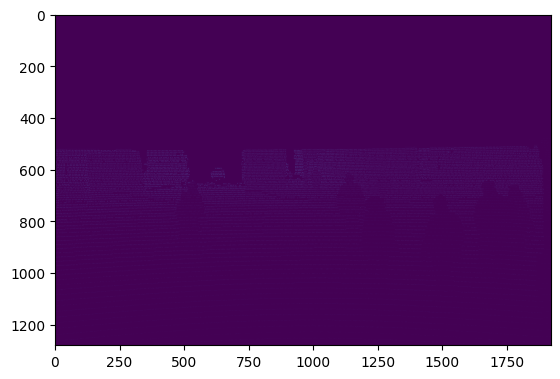

<class 'numpy.ndarray'>


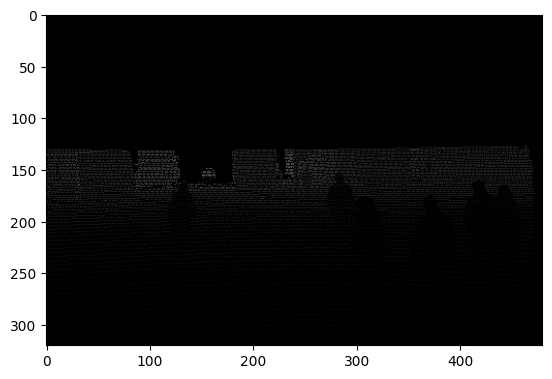

TypeError: Invalid shape (3,) for image data

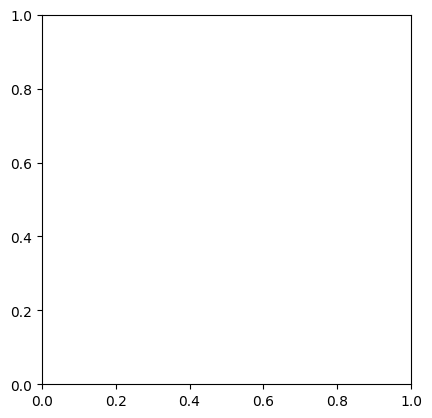

In [13]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread('/home/albyyuggle/Code/CS498/FP/data/30779396576054160_1880_000_1900_000/1557845072664263_cam_1.jpg', cv2.IMREAD_COLOR)
print(img.shape)

dimg = cv2.imread('/home/albyyuggle/Code/CS498/FP/data/30779396576054160_1880_000_1900_000/1557845072664263_depth_1.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(dimg)
plt.show()
dimg_small = torch.nn.MaxPool2d((4,4), stride=(4,4))(torch.unsqueeze(torch.unsqueeze(torch.tensor(dimg, dtype=float), axis=0), axis=0)).repeat((1,3,1,1)).type(torch.IntTensor)
dimg_small = dimg_small[0].permute(1,2,0).numpy()
print(type(dimg_small))
plt.imshow(dimg_small)
plt.show()
plt.imshow(dimg_small[0][0])
plt.show()

1.0 4.927716784522772
1.0 5.684309999999982
2.0 35.52693750000003
2.0 31.421602500000006
1.0 3.947437499999978
1.0 58.737820266017536
1.0 5.684309999999982
1.0 11.684412631573025
1.0 4.894822500000032
2.0 14.052877500000022
1.0 5.684309999999982
1.0 22.895137500000033
1.0 10.105439999999987
1.0 14.052877500000022
2.0 18.15821249999999
2.0 6.315899999999999
4.0 78.31716
1.0 4.421130000000005
2.0 71.58032315266087
2.0 16.895032499999957
2.0 30.94790999999998
1.0 3.947437499999978
2.0 114.55499267687424
2.0 96.08076966295027
1.0 39.79016999999999
1.0 10.594662953534112
2.0 2.684257500000001
1.0 5.684309999999982
1.0 4.894822500000032
2.0 114.38111412375639
1.0 52.553551030689505
2.0 96.73855605342106
1.0 11.842312499999991
2.0 30.00052500000004


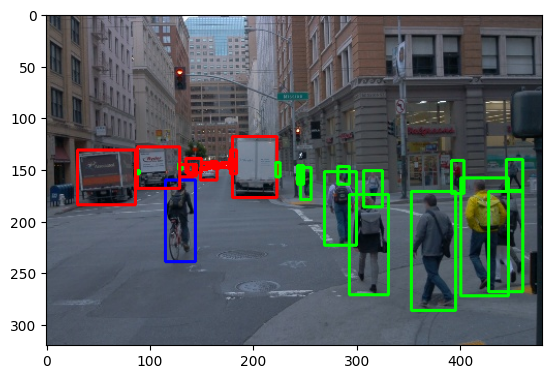

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# select random image from test set
image_name = "test"
image = cv2.imread('/home/albyyuggle/Code/CS498/FP/data/30779396576054160_1880_000_1900_000/1557845072664263_cam_1.jpg', cv2.IMREAD_COLOR)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

boxes = np.load('/home/albyyuggle/Code/CS498/FP/data/30779396576054160_1880_000_1900_000/1557845072664263_boxes_1.npy')

for box in boxes:
    x1,y1, x2, y2,t = box
    if t == 1.0:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
    elif t == 2.0:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    else:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
    #text_size, baseline = cv2.getTextSize(str(t), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)

    #cv2.putText(image, str(t), (x1, y1 + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)
    print(t, y2-y1)

plt.imshow(image)
plt.show()

In [5]:
import cv2 
import numpy as np
import glob
data_dir = "./data/**/*.npy"
file_names = glob.glob(data_dir)
file_names = [f.split('_boxes_')[0]+"_cam_"+f.split('_boxes_')[1][:-3]+"jpg" for f in file_names]
mean = np.array([0.0,0.0,0.0])
j = 0
for f in file_names:
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    #img = cv2.cvtColor(img, cv2.BGR2RGB)
    img = cv2.resize(img, (448, 448))
    for i in range(3):
        mean[i] += np.mean(img[:,:,i])
    j+=1

mean /= j

print(mean)


[80.28508888 88.08055638 96.85002836]


In [9]:
import cv2 
import numpy as np
import glob
data_dir = "./data/**/*.npy"
file_names = glob.glob(data_dir)
file_names = [f.split('_boxes_')[0]+"_cam_"+f.split('_boxes_')[1][:-3]+"jpg" for f in file_names]
mean = 0.0
j = 0
for f in file_names:
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    #img = cv2.cvtColor(img, cv2.BGR2RGB)
    img = cv2.resize(img, (448, 448))
    mean += np.mean(img[:,:])
    j+=1

mean /= j

print(mean)


89.82395056098699
